# SqueezeNet 

In [ ]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import os
import random

# fix random seed for involved libraries
random_seed = 4321
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

In [ ]:
def squeezeNet(input_shape, n_classes):
    def fire(x_in, n_squeeze, n_expand):
        x_sqeeze = tf.keras.layers.Conv2D(n_squeeze, 1, padding ="valid", activation="relu")(x_in)
        x_expand1 = tf.keras.layers.Conv2D(n_expand, 1, padding ="valid", activation="relu")(x_sqeeze)
        x_expand3 = tf.keras.layers.Conv2D(n_expand, 3, padding ="same", activation="relu")(x_sqeeze)
        output = tf.keras.layers.concatenate([x_expand1, x_expand3],axis=3)
        return output
    img_input = tf.keras.Input(input_shape) # size of your pictures
    x = tf.keras.layers.Conv2D(96, 7, strides=2, padding ="same", activation="relu")(img_input)
    x = tf.keras.layers.MaxPool2D(3, strides=2, padding ="same")(x)
    x = fire(x, 16, 64)
    x = fire(x, 16, 64)
    x = fire(x, 32, 128)
    x = tf.keras.layers.MaxPool2D(3, strides=2, padding ="same")(x)
    x = fire(x, 32, 128)
    x = fire(x, 48, 192)
    x = fire(x, 48, 192)
    x = fire(x, 64, 256)
    x = tf.keras.layers.MaxPool2D(3, strides=2, padding ="same")(x)
    x = fire(x, 64, 256)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(n_classes, 1 , strides=1, padding="same")(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    output = tf.keras.layers.Activation("softmax")(x)
    model = tf.keras.models.Model(img_input, output)
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau

# define squeeze net callbacks
def get_squeezeNet_callbacks():
    es_callback = EarlyStopping(monitor='val_loss', patience=25)
    csv_logger = CSVLogger(os.path.join('squeezeNet.log'))
    lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')
    return [es_callback, csv_logger, lr_callback]

In [ ]:
# return steps needed for training and validation with a given batch size
def get_steps_per_epoch(n_data, batch_size):
    if n_data%batch_size==0:
        return int(n_data/batch_size)
    else:
        return int(n_data*1.0/batch_size)+1

# Cifar10

In [ ]:
# Cifar10 has 10 classes
N_CLASSES = 10
# our input dimensions
INSHAPE = 32, 32, 3
BATCH_SIZE = 64

In [ ]:
# get the data
(x_train,y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
# do a 1hot encoding on labels
y_train = tf.keras.utils.to_categorical(y_train, N_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, N_CLASSES)

In [ ]:
# check if data shapes are correct
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


In [ ]:
# augment pictures
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range = 0.1,
    zoom_range = 0.1,
    rotation_range=30,
    horizontal_flip=True,
    validation_split=0.1
    )
# get data generators for training and validation
train_generator = datagen.flow( x_train, y_train, batch_size=BATCH_SIZE, subset='training')
validation_generator = datagen.flow( x_train, y_train, batch_size=BATCH_SIZE, subset='validation')

In [ ]:
# clear old models and create new squeezeNet
tf.keras.backend.clear_session()
model = squeezeNet(INSHAPE, N_CLASSES)
# chekout squeezeNet architecture
#model.summary()

In [ ]:
# training configuration
loss = tf.keras.losses.CategoricalCrossentropy()
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
model_callbacks = get_squeezeNet_callbacks()

In [ ]:
# start training
history = model.fit(train_generator, 
                    epochs=6, 
                    steps_per_epoch = get_steps_per_epoch(int(x_train.shape[0]*0.9), BATCH_SIZE),
                    validation_data=validation_generator , 
                    validation_steps = get_steps_per_epoch(int(x_train.shape[0]*0.1), BATCH_SIZE),
                    verbose = 1,
                    callbacks = model_callbacks)

Epoch 1/6
704/704 [==============================] - 32s 46ms/step - loss: 2.0526 - accuracy: 0.2159 - val_loss: 1.8860 - val_accuracy: 0.2782
Epoch 2/6
704/704 [==============================] - 30s 42ms/step - loss: 1.8301 - accuracy: 0.3085 - val_loss: 1.7499 - val_accuracy: 0.3310
Epoch 3/6
704/704 [==============================] - 32s 45ms/step - loss: 1.7325 - accuracy: 0.3486 - val_loss: 1.6646 - val_accuracy: 0.3718
Epoch 4/6
704/704 [==============================] - 31s 44ms/step - loss: 1.6657 - accuracy: 0.3799 - val_loss: 1.5830 - val_accuracy: 0.4086
Epoch 5/6
704/704 [==============================] - 30s 42ms/step - loss: 1.5991 - accuracy: 0.4083 - val_loss: 1.5628 - val_accuracy: 0.4242
Epoch 6/6
704/704 [==============================] - 31s 45ms/step - loss: 1.5504 - accuracy: 0.4273 - val_loss: 1.4805 - val_accuracy: 0.4532


In [ ]:
import matplotlib.pyplot as plt
def plot_accuracy_and_loss(history):
    figure = plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    figure.savefig("squeezeNet.pdf", bbox_inches='tight')
    plt.show()

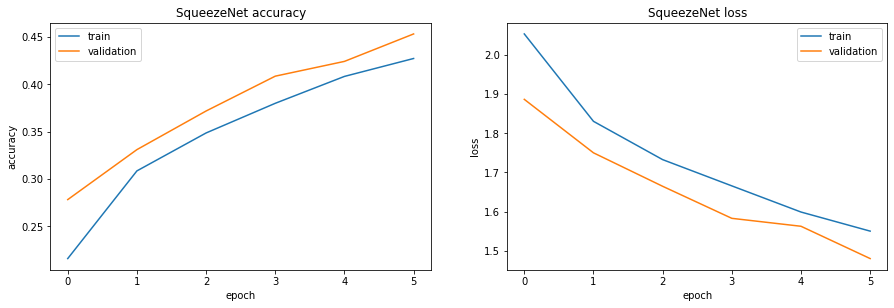

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
if not os.path.exists('models'):
    os.mkdir("models")
model.save(os.path.join('models', 'squeezeNet_cifar10.h5'))

# Tiny ImageNet

In [ ]:
# TinyIageNet has 200 classes
N_CLASSES = 200
# our input dimensions
INSHAPE = 64, 64, 3
PICTURE_SHAPE = INSHAPE[0], INSHAPE[1]
BATCH_SIZE = 64

In [ ]:
# download tiny Imagenet and create folder
import os
import requests
import zipfile

# Retrieve the data
if not os.path.exists(os.path.join('data','tiny-imagenet-200.zip')):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    # Get the file from web
    r = requests.get(url)

    if not os.path.exists('data'):
        os.mkdir('data')
    
  # Write to a file
    with open(os.path.join('data','tiny-imagenet-200.zip'), 'wb') as f:
        f.write(r.content)
else:
      print("The zip file already exists.")
    
if not os.path.exists(os.path.join('data', 'tiny-imagenet-200')):
    with zipfile.ZipFile(os.path.join('data','tiny-imagenet-200.zip'), 'r') as zip_ref:
        zip_ref.extractall('data')
else:
    print("The extracted data already exists")

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(
                  #rescale=1./255,# this didnt work
                  width_shift_range=0.1, 
                  height_shift_range=0.1, 
                  shear_range = 0.1,
                  zoom_range = 0.1,
                  rotation_range=30,
                  horizontal_flip=True,
                  validation_split=0.1)

train_gen = image_gen.flow_from_directory(directory='./data/tiny-imagenet-200/train', 
    target_size=PICTURE_SHAPE, classes=None,
    class_mode='categorical', batch_size=BATCH_SIZE, 
    shuffle=True, seed=random_seed,subset='training')

valid_gen = image_gen.flow_from_directory(directory='./data/tiny-imagenet-200/train', 
    target_size=PICTURE_SHAPE, classes=None,
    class_mode='categorical', batch_size=BATCH_SIZE, 
    shuffle=True, seed=random_seed,subset='validation')

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [ ]:
# clear old models and create new squeezeNet
tf.keras.backend.clear_session()
model = squeezeNet(INSHAPE, N_CLASSES)
# chekout squeezeNet architecture
#model.summary()

In [ ]:
# training configuration
loss = tf.keras.losses.CategoricalCrossentropy()
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
model_callbacks = get_squeezeNet_callbacks()

In [ ]:
history = model.fit(
    train_gen, 
    validation_data = valid_gen, 
    steps_per_epoch = get_steps_per_epoch(int(0.9*(500*200)), BATCH_SIZE), 
    validation_steps = get_steps_per_epoch(int(0.1*(500*200)), BATCH_SIZE),
    epochs = 6,
    verbose = 1,
    callbacks = model_callbacks)

Epoch 1/6
1407/1407 [==============================] - 161s 114ms/step - loss: 5.2297 - accuracy: 0.0069 - val_loss: 5.1261 - val_accuracy: 0.0097
Epoch 2/6
1407/1407 [==============================] - 158s 113ms/step - loss: 5.0247 - accuracy: 0.0194 - val_loss: 4.9063 - val_accuracy: 0.0286
Epoch 3/6
1407/1407 [==============================] - 157s 112ms/step - loss: 4.7882 - accuracy: 0.0394 - val_loss: 4.6732 - val_accuracy: 0.0525
Epoch 4/6
1407/1407 [==============================] - 158s 113ms/step - loss: 4.6164 - accuracy: 0.0577 - val_loss: 4.5095 - val_accuracy: 0.0725
Epoch 5/6
1407/1407 [==============================] - 158s 112ms/step - loss: 4.4799 - accuracy: 0.0725 - val_loss: 4.3726 - val_accuracy: 0.0862
Epoch 6/6
1407/1407 [==============================] - 156s 111ms/step - loss: 4.3586 - accuracy: 0.0883 - val_loss: 4.2951 - val_accuracy: 0.0945


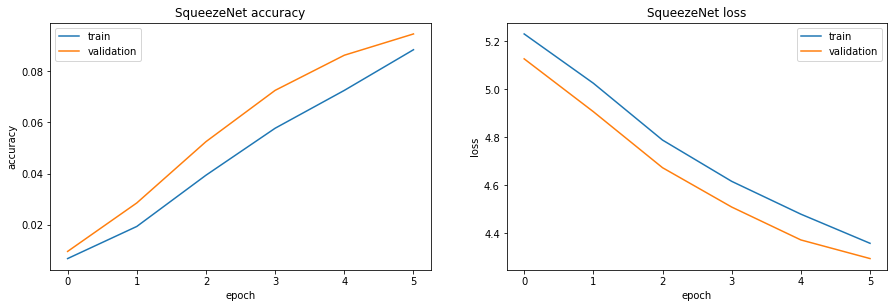

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
if not os.path.exists('models'):
    os.mkdir("models")
model.save(os.path.join('models', 'squeezeNet_tinyimageNet.h5'))

# ResNet50 transfer learning

In [ ]:
import numpy as np
import pandas as pd 
from tensorflow import keras
import tensorflow as tf
import os

In [ ]:
def res50Net_transfer(input_shape, n_classes, frozen_layers=168, final_layers=[]):
    # load resnet with given input shape
    input_t = tf.keras.Input(shape=input_shape)
    res_model = tf.keras.applications.ResNet50(include_top=False,
                                              weights="imagenet",
                                              input_tensor=input_t)
    # freeze top layers of resnet
    for layer in res_model.layers[:frozen_layers]:
        layer.trainable =False

    # wrap resnet by sequencial network
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, input_shape[:2])))
    model.add(res_model)
    model.add(tf.keras.layers.Flatten())

    for n_layer in final_layers: # add dense layers if we need more accuracy
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(n_layer, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

    loss = tf.keras.losses.CategoricalCrossentropy()
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau

def get_res50Net_transfer_callbacks():
    es_callback = EarlyStopping(monitor='val_loss', patience=25)
    csv_logger = CSVLogger(os.path.join('res50Net_transfer.log'))
    lr_callback = ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'
    )
    return [es_callback, csv_logger, lr_callback]

In [ ]:
def get_steps_per_epoch(n_data, batch_size):
    """ Given the data size and batch size, gives the number of steps to travers the full dataset """
    if n_data%batch_size==0:
        return int(n_data/batch_size)
    else:
        return int(n_data*1.0/batch_size)+1

In [ ]:
import matplotlib.pyplot as plt
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('ResNet50 accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('ResNet50 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

## Cifar10

In [ ]:
# Cifar10 has 10 classes
N_CLASSES = 10
# our input dimensions
INSHAPE = 32, 32, 3

In [ ]:
# get the data
(x_train,y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
# do a 1hot encoding on labels
y_train = tf.keras.utils.to_categorical(y_train, N_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, N_CLASSES)

In [ ]:
# check if data shapes are correct
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


In [ ]:
# augment pictures
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True)

In [ ]:
# clear old models and create new squeezeNet
tf.keras.backend.clear_session()
model = res50Net_transfer(INSHAPE, N_CLASSES, frozen_layers=168, 
                          final_layers=[256, 128, 64])
model_callbacks = get_res50Net_transfer_callbacks()

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
# generator for data augmentation with 64 pictures per step generated
it_train = datagen.flow(x_train, y_train, batch_size=64)
steps = x_train.shape[0] // 64 # total steps needed to iterate all pictures

In [ ]:
history = model.fit(it_train, epochs=2, 
                    verbose=1, steps_per_epoch=steps, 
                    validation_data=(x_test, y_test), 
                    callbacks= model_callbacks)

Epoch 1/2
781/781 [==============================] - 31s 40ms/step - loss: 1.8066 - accuracy: 0.3627 - val_loss: 1.4141 - val_accuracy: 0.5228
Epoch 2/2
781/781 [==============================] - 33s 43ms/step - loss: 1.6952 - accuracy: 0.4008 - val_loss: 1.3391 - val_accuracy: 0.5527


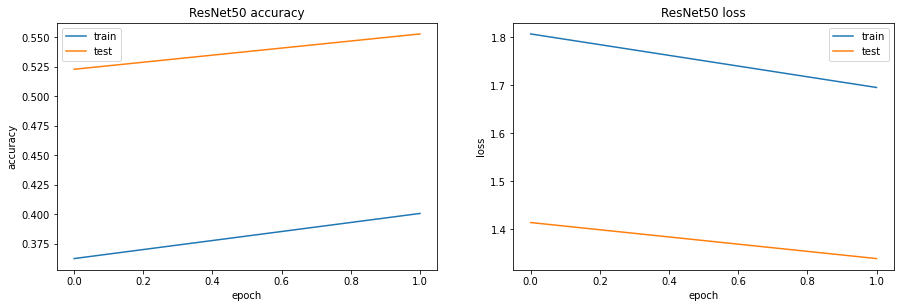

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
if not os.path.exists('models'):
    os.mkdir("models")
model.save(os.path.join('models', 'res50Net_cifar10.h5'))

## Tiny ImageNet

In [ ]:
# TinyIageNet has 200 classes
N_CLASSES = 200
# our input dimensions
INSHAPE = 64, 64, 3
PICTURE_SHAPE = (INSHAPE[0], INSHAPE[1])
BATCH_SIZE = 32

In [ ]:
import numpy as np
import tensorflow as tf
import random

In [ ]:
# Fixing the random seed for involved libraries
random_seed=4321

np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

In [ ]:
# download tiny Imagenet and create folder
import os
import requests
import zipfile

# Retrieve the data
if not os.path.exists(os.path.join('data','tiny-imagenet-200.zip')):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    # Get the file from web
    r = requests.get(url)

    if not os.path.exists('data'):
        os.mkdir('data')
    
    # Write to a file
    with open(os.path.join('data','tiny-imagenet-200.zip'), 'wb') as f:
        f.write(r.content)
else:
    print("The zip file already exists.")
    
if not os.path.exists(os.path.join('data', 'tiny-imagenet-200')):
    with zipfile.ZipFile(os.path.join('data','tiny-imagenet-200.zip'), 'r') as zip_ref:
        zip_ref.extractall('data')
else:
    print("The extracted data already exists")

The zip file already exists.
The extracted data already exists


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# if we want to augment the data
AUGMENT = True

if AUGMENT:
    image_gen = ImageDataGenerator(
                      #rescale=1./255, # this didnt work
                      width_shift_range=0.1, 
                      height_shift_range=0.1, 
                      shear_range = 0.1,
                      zoom_range = 0.1,
                      rotation_range=30,
                      horizontal_flip=True,
                      validation_split=0.1)
else:
    image_gen = ImageDataGenerator(samplewise_center=False, validation_split=0.1)

train_gen = image_gen.flow_from_directory(directory='./data/tiny-imagenet-200/train', 
    target_size=PICTURE_SHAPE, classes=None,
    class_mode='categorical', batch_size=BATCH_SIZE, 
    shuffle=True, seed=random_seed,subset='training')

valid_gen = image_gen.flow_from_directory(directory='./data/tiny-imagenet-200/train', 
    target_size=PICTURE_SHAPE, classes=None,
    class_mode='categorical', batch_size=BATCH_SIZE, 
    shuffle=True, seed=random_seed,subset='validation')

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [ ]:
# clear old models and create new squeezeNet
tf.keras.backend.clear_session()
model = res50Net_transfer(INSHAPE, N_CLASSES, frozen_layers=168, 
                          final_layers=[256, 256])
model_callbacks = get_res50Net_transfer_callbacks()

In [ ]:
history = model.fit(
    train_gen, validation_data=valid_gen,
    steps_per_epoch=get_steps_per_epoch(int(0.9*(500*200)), BATCH_SIZE),
    validation_steps=get_steps_per_epoch(int(0.1*(500*200)), BATCH_SIZE),
    epochs=2, callbacks= model_callbacks,
    verbose=1)

Epoch 1/2
2813/2813 [==============================] - 183s 63ms/step - loss: 5.3842 - accuracy: 0.0194 - val_loss: 4.1379 - val_accuracy: 0.1626
Epoch 2/2
2813/2813 [==============================] - 176s 63ms/step - loss: 4.4646 - accuracy: 0.0852 - val_loss: 3.6161 - val_accuracy: 0.2206


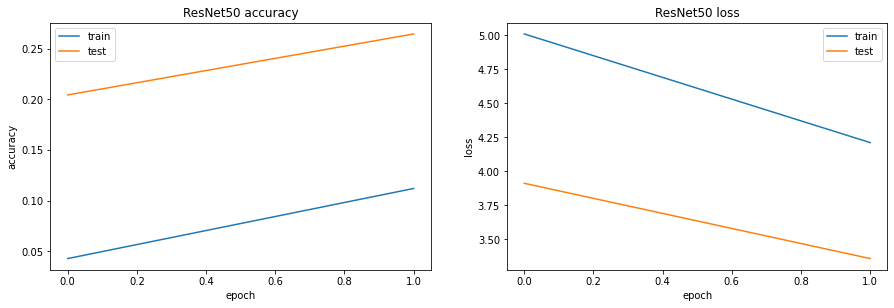

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
if not os.path.exists('models'):
    os.mkdir("models")
model.save(os.path.join('models', 'res50Net_tinyimageNet.h5'))